In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.utils import restricted_mean_survival_time

In [2]:
# read data
df = pd.read_csv('loan_timing.csv', encoding='utf-8')

In [3]:
# show top 5
df.head()

,days since origination,days from origination to chargeoff
0,109,NaN
1,679,NaN
2,723,NaN
3,509,NaN
4,254,NaN


In [4]:
# rename columns
df = df.rename(columns={"days since origination":"origination", "days from origination to chargeoff": "charge_off"})

array([[<AxesSubplot:title={'center':'origination'}>,
        <AxesSubplot:title={'center':'charge_off'}>]], dtype=object)

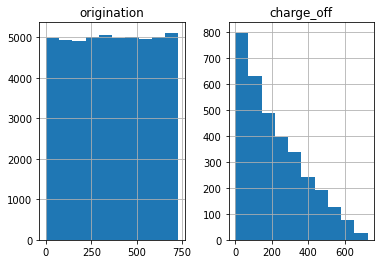

In [5]:
df.hist()

### Observation
A uniform normal distribution is observed over days since origination and the proportion of loans that charged off decreases with increasing days from origination to charge-off

In [6]:
#assess information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   origination  50000 non-null  int64  
 1   charge_off   3305 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 781.4 KB


#### Notes:
There are `46695` missing values in the column we are trying to predict (days from origination to chargeoff)

In [7]:
# drop missing values
df_new = df.dropna(axis=0)

In [8]:
# see stratistics
df_new.describe()

,origination,charge_off
count,3305.000000,3305.000000
mean,474.198790,214.852345
std,176.942232,165.233874
min,10.000000,0.000000
25%,343.000000,76.000000
50%,501.000000,180.000000
75%,625.000000,323.000000
max,730.000000,725.000000


array([[<AxesSubplot:title={'center':'origination'}>,
        <AxesSubplot:title={'center':'charge_off'}>]], dtype=object)

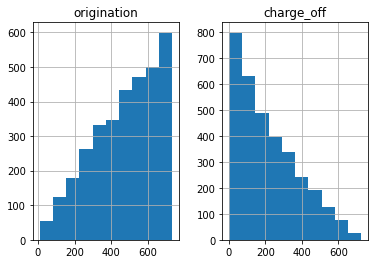

In [9]:
# plot a histogram of the data
df_new.hist()

#### Overview:
The days since origination are seen to increase daily with time

In [10]:
# instantiate the model
kmf = KaplanMeierFitter()

In [11]:
df_new.head()

,origination,charge_off
14,327,78.0
15,400,390.0
16,721,362.0
26,410,48.0
61,649,412.0


In [12]:
df_new.charge_off.value_counts()

70.0     19
67.0     17
65.0     17
0.0      16
82.0     16
         ..
531.0     1
396.0     1
645.0     1
556.0     1
661.0     1
Name: charge_off, Length: 628, dtype: int64

In [13]:
# fit the model
kmf.fit(durations=df_new['origination'], event_observed=df_new['charge_off'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 3305 total observations, 16 right-censored observations>

In [14]:
# event table
# removed = observed + censored
# observed = charged off days
# censored = days that did not charge off
# at_risk days under observation currently
# entrance new charge off days at a given timeline 
kmf.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,3305,3305
10.0,1,0,1,0,3305
14.0,1,1,0,0,3304
17.0,1,1,0,0,3303
18.0,1,1,0,0,3302
...,...,...,...,...,...
726.0,10,10,0,0,50
727.0,8,8,0,0,40
728.0,12,12,0,0,32


In [15]:
kmf.predict([10,730, 750, 850, 890, 900, 960, 1030, 3*365])

10      1.0
730     0.0
750     0.0
850     0.0
890     0.0
900     0.0
960     0.0
1030    0.0
1095    0.0
Name: KM_estimate, dtype: float64

In [16]:
# survival probality of the whole timeline
kmf.survival_function_

,KM_estimate
timeline,
0.0,1.000000
10.0,1.000000
14.0,0.999697
17.0,0.999395
18.0,0.999092
...,...
726.0,0.012449
727.0,0.009959
728.0,0.006225


Text(0, 0.5, 'Probability of survival')

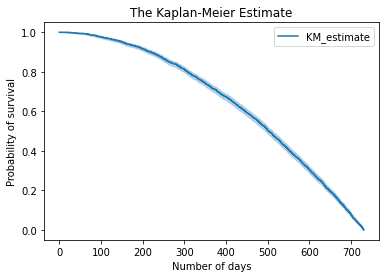

In [17]:
kmf.plot()
plt.title('The Kaplan-Meier Estimate')
plt.xlabel('Number of days')
plt.ylabel('Probability of survival')

#### Notes
Chances of survival decrease with time

In [18]:
# median survival time
median = kmf.median_survival_time_
median

502.0

### Notes
An average loan was charged off 502 days since origination 

In [19]:
conf = kmf.confidence_interval_survival_function_

In [20]:
kmf.confidence_interval_survival_function_

,KM_estimate_lower_0.95,KM_estimate_upper_0.95
0.0,1.000000,1.000000
10.0,1.000000,1.000000
14.0,0.997853,0.999957
17.0,0.997582,0.999849
18.0,0.997187,0.999707
...,...,...
726.0,0.009064,0.016736
727.0,0.006973,0.013865
728.0,0.003949,0.009451
729.0,0.001621,0.005593


Text(0, 0.5, 'Probability of survival')

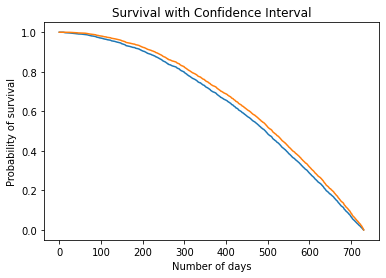

In [21]:
plt.plot(conf['KM_estimate_lower_0.95'], label='lower')
plt.plot(conf['KM_estimate_upper_0.95'], label='upper')
plt.legend
plt.title('Survival with Confidence Interval')
plt.xlabel('Number of days')
plt.ylabel('Probability of survival')

In [22]:
rmst_exp = restricted_mean_survival_time(kmf, t=3*365) #t=time_limit

In [23]:
# fraction charged off loans
rmst_exp/len(df_new.index)

0.1438698299601726

#### Note: The estimated fraction of charged off loans is 14.3%